# TLDR.
<font size="4">This model uses the U-Net architecture, with a VGG16 backbone and Imagenet weights, to produce a multi class segmentation mask. The input image size is 512x512, because of memory constraints. When running the model on the testing set, I got an IoU of 0.66 and a F1 score of 0.68. 
<br> Finally, there are multiple methods I would like to explore, in order to improve my model: <br> - Increasing the resolution of the images using a more powerful maching
<br> - Using ensemble learning with other architectures and backbones
<br> - More hyperparameter tuning
</font>

# Setup

## Installs

In [1]:
!pip install scikit-learn -q
!pip install tqdm -q
!pip install albumentations -q
!pip install pandas -q
%env SM_FRAMEWORK=tf.keras
!pip install segmentation_models -q
!pip install seaborn -q

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
env: SM_FRAMEWORK=tf.keras
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


## Imports

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import segmentation_models as sm

import random
import pandas as pd
import numpy as np
import json

from PIL import Image
import albumentations as A
import matplotlib.pyplot as plt
import seaborn as sns

import os
import json
from tqdm.notebook import tqdm

random.seed(0)
np.random.seed(0)

Segmentation Models: using `tf.keras` framework.


# Data Source!!!
__Link:__ https://www.mapillary.com/dataset/vistas

In [3]:
DATASET_PATH = 'data/dataset/'

# Exploration

## Check Dataset Size

In [4]:
def get_paths(path, name):
    images = []
    for file in os.listdir(path):
        if file.endswith(".jpg") or file.endswith(".png"):
            images.append(file)
    print(len(images), f'images in {name} set')
    return sorted([path+img for img in images])
    
train_imgs = get_paths(DATASET_PATH+"training/images/", 'training')
test_imgs = get_paths(DATASET_PATH+"testing/images/", 'testing')
val_imgs = get_paths(DATASET_PATH+"validation/images/", 'validation')

18000 images in training set
5000 images in testing set
2000 images in validation set


## Image Sizes

In [5]:
hs = []
ws = []
for img in tqdm(train_imgs):
    ims = np.asarray(Image.open(img)).shape
    hs.append(ims[0])
    ws.append(ims[1])
    
hs = np.array(hs)
ws = np.array(ws)

  0%|          | 0/18000 [00:00<?, ?it/s]

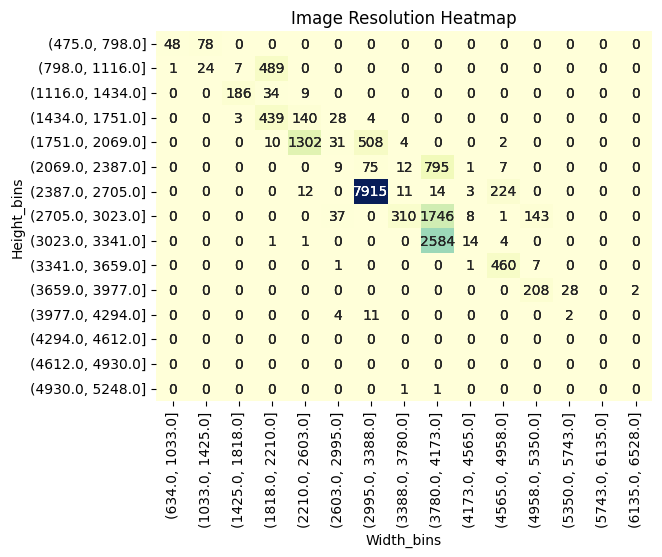

In [8]:
plot_data = (
    pd.DataFrame(np.column_stack((hs, ws)), columns=['Height', 'Width'])
    .assign(Height_bins=pd.cut(hs, bins=15, precision=0))
    .assign(Width_bins=pd.cut(ws, bins=15, precision=0))
    .groupby(by=['Height_bins', 'Width_bins'])
    .size().reset_index(name='Count')
)
sns.heatmap(
    data=plot_data.pivot(
        index='Height_bins', 
        columns='Width_bins', 
        values='Count'),
    cmap='YlGnBu', 
    annot=True,
    fmt='d',
    cbar=False
)

plt.title('Image Resolution Heatmap')
plt.show()
plt.close()

<font size="4">A lot of the images/masks have a very high resolution, with a mean resolution of around 4k. This would take up a lot of resources and I don't have the resources to store many images at this resolution. The comprimise I decided on was to resize all the images to 512x512. It would allow me to fit 6000 image and mask pairs into my training set. Moreover, the testing and training sets will have 1000 images each.</font>

## Mask Versions

### v1.2 masks

In [9]:
v12_dict = {}
with open(DATASET_PATH+'config_v1.2.json') as json_file:
    raw_v12_dict = json.load(json_file)['labels']
    for i in range(len(raw_v12_dict)):
        dicti = raw_v12_dict[i]
        dicti['id'] = i
        dicti['name'] = dicti['readable']
        dicti.pop("readable")
        dicti.pop("evaluate")
        dicti.pop("instances")
        v12_dict.update({
            i:dicti
        })
        
v12_dict

{0: {'color': [165, 42, 42], 'name': 'Bird', 'id': 0},
 1: {'color': [0, 192, 0], 'name': 'Ground Animal', 'id': 1},
 2: {'color': [196, 196, 196], 'name': 'Curb', 'id': 2},
 3: {'color': [190, 153, 153], 'name': 'Fence', 'id': 3},
 4: {'color': [180, 165, 180], 'name': 'Guard Rail', 'id': 4},
 5: {'color': [90, 120, 150], 'name': 'Barrier', 'id': 5},
 6: {'color': [102, 102, 156], 'name': 'Wall', 'id': 6},
 7: {'color': [128, 64, 255], 'name': 'Bike Lane', 'id': 7},
 8: {'color': [140, 140, 200], 'name': 'Crosswalk - Plain', 'id': 8},
 9: {'color': [170, 170, 170], 'name': 'Curb Cut', 'id': 9},
 10: {'color': [250, 170, 160], 'name': 'Parking', 'id': 10},
 11: {'color': [96, 96, 96], 'name': 'Pedestrian Area', 'id': 11},
 12: {'color': [230, 150, 140], 'name': 'Rail Track', 'id': 12},
 13: {'color': [128, 64, 128], 'name': 'Road', 'id': 13},
 14: {'color': [110, 110, 110], 'name': 'Service Lane', 'id': 14},
 15: {'color': [244, 35, 232], 'name': 'Sidewalk', 'id': 15},
 16: {'color': [

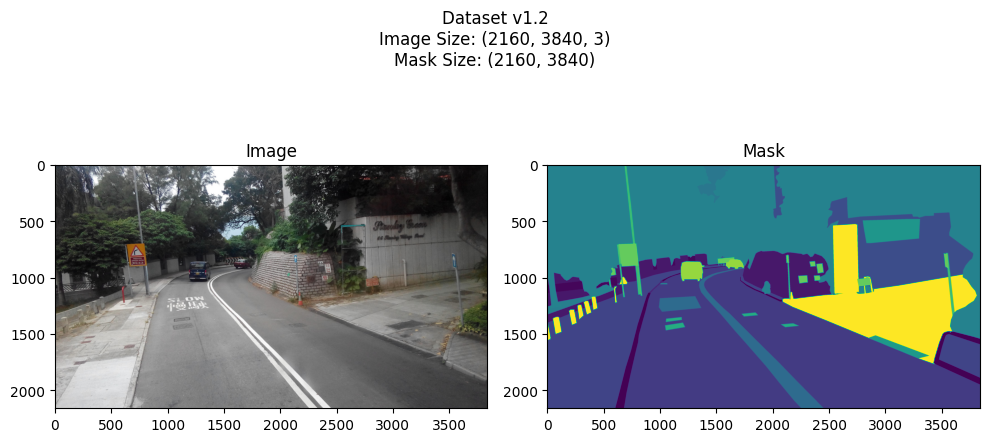

In [10]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

plot_img_X = np.asarray(Image.open(DATASET_PATH+"training/images/-0C1J9CvgFP4BTVLXNeNZA.jpg"))
plot_img_y = np.asarray(Image.open(DATASET_PATH+"training/v1.2/labels/-0C1J9CvgFP4BTVLXNeNZA.png"))

ax[0].imshow(plot_img_X)
ax[0].set_title('Image')

ax[1].imshow(plot_img_y)
ax[1].set_title('Mask')

fig.suptitle(f'Dataset v1.2\nImage Size: {plot_img_X.shape}\nMask Size: {plot_img_y.shape}')

fig.tight_layout()
plt.show(fig)
plt.close(fig)

### v2.0 masks

In [11]:
v20_dict = {}
with open(DATASET_PATH+'config_v2.0.json') as json_file:
    raw_v20_dict = json.load(json_file)['labels']
    for i in range(len(raw_v20_dict)):
        dicti = raw_v20_dict[i]
        dicti['id'] = i
        dicti['name'] = dicti['readable']
        dicti.pop("readable")
        dicti.pop("evaluate")
        dicti.pop("instances")
        v20_dict.update({
            i:dicti
        })
        
v20_dict

{0: {'name': 'Bird', 'color': [165, 42, 42], 'id': 0},
 1: {'name': 'Ground Animal', 'color': [0, 192, 0], 'id': 1},
 2: {'name': 'Ambiguous Barrier', 'color': [250, 170, 31], 'id': 2},
 3: {'name': 'Concrete Block', 'color': [250, 170, 32], 'id': 3},
 4: {'name': 'Curb', 'color': [196, 196, 196], 'id': 4},
 5: {'name': 'Fence', 'color': [190, 153, 153], 'id': 5},
 6: {'name': 'Guard Rail', 'color': [180, 165, 180], 'id': 6},
 7: {'name': 'Barrier', 'color': [90, 120, 150], 'id': 7},
 8: {'name': 'Road Median', 'color': [250, 170, 33], 'id': 8},
 9: {'name': 'Road Side', 'color': [250, 170, 34], 'id': 9},
 10: {'name': 'Lane Separator', 'color': [128, 128, 128], 'id': 10},
 11: {'name': 'Temporary Barrier', 'color': [250, 170, 35], 'id': 11},
 12: {'name': 'Wall', 'color': [102, 102, 156], 'id': 12},
 13: {'name': 'Bike Lane', 'color': [128, 64, 255], 'id': 13},
 14: {'name': 'Crosswalk - Plain', 'color': [140, 140, 200], 'id': 14},
 15: {'name': 'Curb Cut', 'color': [170, 170, 170], '

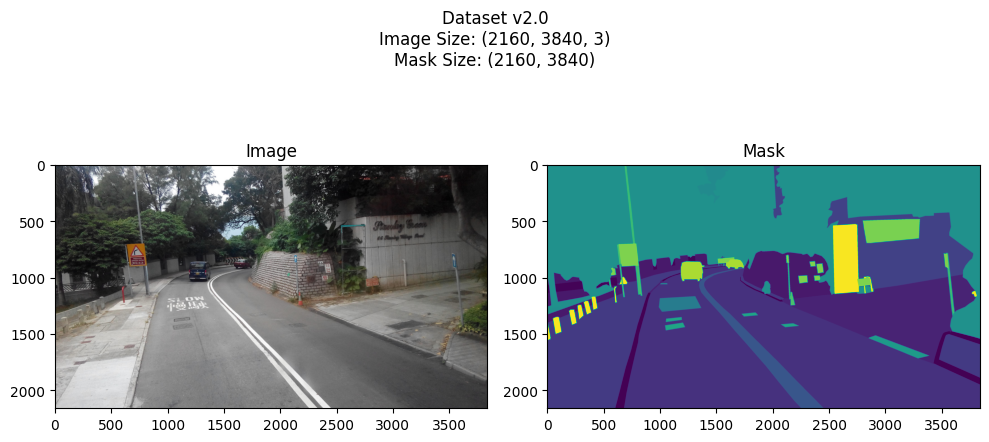

In [12]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

plot_img_X = np.asarray(Image.open(DATASET_PATH+"training/images/-0C1J9CvgFP4BTVLXNeNZA.jpg"))
plot_img_y = np.asarray(Image.open(DATASET_PATH+"training/v2.0/labels/-0C1J9CvgFP4BTVLXNeNZA.png"))

ax[0].imshow(plot_img_X)
ax[0].set_title('Image')

ax[1].imshow(plot_img_y)
ax[1].set_title('Mask')

fig.suptitle(f'Dataset v2.0\nImage Size: {plot_img_X.shape}\nMask Size: {plot_img_y.shape}')

fig.tight_layout()
plt.show(fig)
plt.close(fig)

## Picking Mask Version

<font size="4">To avoid having a bigger class imbalance, I decided to keep the amount of classes as low as possible. Due to this reason, I chose the v1.2 masks. This version of the dataset, has 65 classes and 1 void/unlabeled class. Luckily, the masks have a shape of (512, 512, 1) after the resizing operation, so there is no preprocessing needed to extract the classes.</font>

# Model

In [13]:
# Target Image Size
HEIGHT = 512
WIDTH = 512

## Data Generator

In [14]:
class StreetViewDataset(tf.keras.utils.Sequence):
    def __init__(self, classes, classes_dict, image_size, X_paths, y_paths, batch_size):
        self.classes = classes
        self.classes_dict = classes_dict
        self.image_size=image_size
        self.x_paths = X_paths
        self.x = self.load_img(self.x_paths)
        self.y_paths = y_paths
        self.y = self.load_img(self.y_paths)
        self.batch_size = batch_size
        self.augmentation_pipeline = A.Compose([
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=45, p=0.5),
            A.GaussNoise (var_limit=(0, 100.0), mean=0, per_channel=False, p=0.5),
            A.Resize(height=self.image_size[0], width=self.image_size[1], always_apply=True)
        ]) 
        self.augmented = self.augment_data()

    def load_img(self, paths):
        imgs = []
        for path in tqdm(paths, desc="Loading Images"):
            img = Image.open(path).resize(self.image_size)
            imgs.append(np.asarray(img))
        return imgs
    
    def augment_data(self):
        images = []
        masks = []
        for img, mask in tqdm(zip(self.x, self.y), desc="Augmenting Images"):
            augmented = self.augmentation_pipeline(image=img, mask=mask)
            images.append(augmented['image'])
            masks.append(augmented['mask'])
        self.x = np.array(images, dtype='float16')/255
        self.y = np.array(masks, dtype='int8')
        return True

    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, idx):
        low = idx * self.batch_size
        high = min(low + self.batch_size, len(self.x))
        batch_x = self.x[low:high]
        batch_y = self.y[low:high]
        
        batch_y_cat = tf.one_hot(
            batch_y, 
            self.classes,
            dtype='float16'
        )
        return batch_x, batch_y_cat

### Data Augmentation Explanation
<font size="4">To add more variation to the dataset, a couple data augmentation techniques are applied. Other than the resize operation, the probabilities are set to 0.5, which means that there is a 50% chance that the augmentation will be applied. Also, due to the fact that the interactions between the operations don't create a negative effect, they all have a chance to be applied at the same time. Furthermore, the images are normalized by dividing the arrays by 255 to set each value between 0 and 1, to help with performance.</font>

### Data Augmentation and Image Preprocessing Omissions
<font size="4">Initially, distortion operations, such as grid distortion and elastic distortion, were applied for data augmentation. Although, this is very common, in most cases, this dataset already contains a variety of lense distortions (such as includes glare, fish eye lense, rectilinear lens, etc.). Due to this and because of a marginal performance difference, I decided to keep the natural variation in the images. 
<br><br>Also, at first, I decided to apply contrast limited adaptive histogram equalization to help with visibility in the images. The idea behind this was to help the model detect smaller objects. Instead, it introduced a lot of artifacts to the image, which decreased performance.</font>

## Load Training, Validation and Testing Data

In [15]:
training_data = list(zip(
    get_paths(DATASET_PATH+"training/images/", 'training images'),
    get_paths(DATASET_PATH+"training/v1.2/labels/", 'training masks')
))
random.shuffle(training_data)

training_set = np.array(random.sample(training_data, 6000))

validation_data = list(zip(
    get_paths(DATASET_PATH+"validation/images/", 'validation images'),
    get_paths(DATASET_PATH+"validation/v1.2/labels/", 'validation masks')
))
random.shuffle(validation_data)

val_test_set = np.array(random.sample(validation_data, 2000))
validation_set = val_test_set[1000:]
test_set = val_test_set[:1000]

18000 images in training images set
18000 images in training masks set
2000 images in validation images set
2000 images in validation masks set


In [16]:
training = StreetViewDataset(
    classes=len(v12_dict), 
    classes_dict=v12_dict,
    image_size=(WIDTH, HEIGHT), 
    X_paths=training_set[:,0], 
    y_paths=training_set[:,1], 
    batch_size=2
)

validation = StreetViewDataset(
    classes=len(v12_dict), 
    classes_dict=v12_dict,
    image_size=(WIDTH, HEIGHT),  
    X_paths=validation_set[:,0], 
    y_paths=validation_set[:,1], 
    batch_size=2
)

testing = StreetViewDataset(
    classes=len(v12_dict), 
    classes_dict=v12_dict,
    image_size=(WIDTH, HEIGHT),  
    X_paths=test_set[:,0], 
    y_paths=test_set[:,1], 
    batch_size=2
)

Loading Images:   0%|          | 0/6000 [00:00<?, ?it/s]

Loading Images:   0%|          | 0/6000 [00:00<?, ?it/s]

Augmenting Images: 0it [00:00, ?it/s]

Loading Images:   0%|          | 0/1000 [00:00<?, ?it/s]

Loading Images:   0%|          | 0/1000 [00:00<?, ?it/s]

Augmenting Images: 0it [00:00, ?it/s]

Loading Images:   0%|          | 0/1000 [00:00<?, ?it/s]

Loading Images:   0%|          | 0/1000 [00:00<?, ?it/s]

Augmenting Images: 0it [00:00, ?it/s]

## Image and Mask Preview

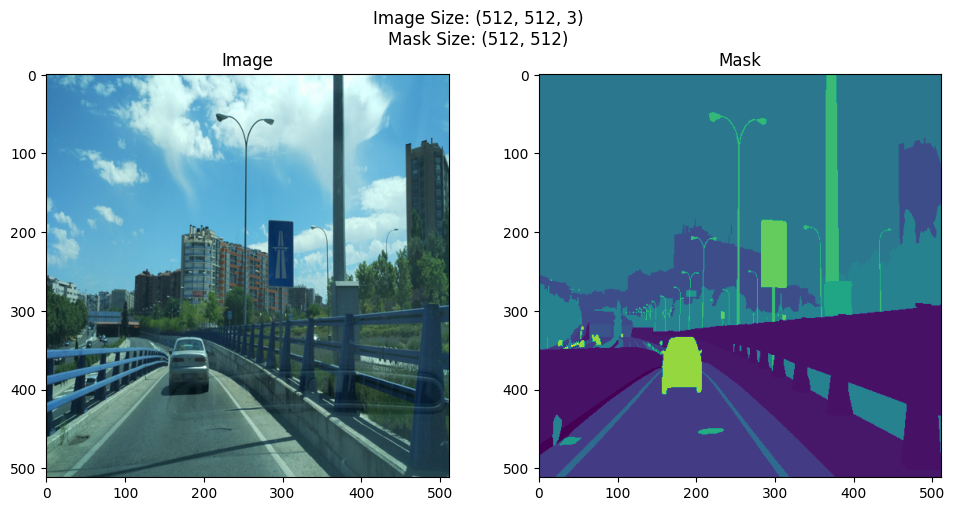

In [17]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

plot_img_X = training.x[7]*255
plot_img_y = training.y[7]

ax[0].imshow(plot_img_X.astype('uint8'))
ax[0].set_title('Image')

ax[1].imshow(plot_img_y)
ax[1].set_title('Mask')

fig.suptitle(f'Image Size: {plot_img_X.shape}\nMask Size: {plot_img_y.shape}')

fig.tight_layout()
plt.show(fig)
plt.close(fig)

## U-Net

<img src="https://www.researchgate.net/publication/331406702/figure/fig2/AS:731276273262594@1551361258173/Illustration-of-the-U-net-architecture-The-figure-illustrates-the-U-net-architecture.png" width=2000 />

<font size="4">For this problem, the U-Net architecture was chosen, because of it is very good at extracting features in a variety of different application. This makes it a good choice when having a small training sample and when considering the various issues with this dataset (big class imbalance and memory insufficiency).
<br><br> U-Net works by having two sides, a encoder and decoder. The encoder downsamples the image, using convolutional layers and max pooling layers, to create feature maps. The decoder then upsamples result and concatenates it with the mirrored encoder, to regain the original shape and get more detail from the image. The output is then passed through a convolutional layer to produce a prediction.
<br><br> I found, through research and tests, that using VGG16 layers for the encoder dramatically improves the performance of the model. This is because VGG16 has been trained with a lot of different image data (imagenet) and can already recognize many details in images. This is used to boost the performance of the model.
</font>

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import applications


class UNet():
    def __init__(self, n_classes, input_size, n_conv, padding, batchnorm, backbone, dropout):
        self.n_classes = n_classes
        self.input_size = input_size
        self.n_conv = n_conv
        self.padding = padding
        self.batchnorm = batchnorm
        self.backbone = backbone
        self.dropout = dropout
        
    def VGG(self, inputs):
        return applications.vgg19.VGG19(
            include_top=False,
            weights='imagenet',
            input_tensor=inputs,
            input_shape=self.input_size
        )
    
    def multi_conv2d(self, inputs, filters):
        x = layers.Conv2D(filters, (3,3), padding=self.padding)(inputs)
        if self.batchnorm:
            x = BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        
        i = self.n_conv-1
        while i >= 1:
            if self.dropout:
                x = layers.Dropout(0.25)(x)
            x = layers.Conv2D(filters, (3,3), padding=self.padding)(x)
            if self.batchnorm:
                x = BatchNormalization()(x)
            x = layers.Activation('relu')(x)
            i -=1
        return x
    
    def decoder(self, inputs, skiplayer, filters):
        x = Conv2DTranspose(filters, (2,2), strides=2, padding=self.padding)(inputs)
        g = layers.Concatenate()([x, skiplayer])
        g = self.multi_conv2d(g, filters)
        return g
    
    def model(self):
        inputs = layers.Input(shape=self.input_size)
        if self.backbone == None:
            s1 = self.multi_conv2d(inputs, filters=64)
            s1_out = layers.MaxPooling2D(pool_size=(2, 2))(s1)
            s2 = self.multi_conv2d(s1_out, filters=128)
            s2_out = layers.MaxPooling2D(pool_size=(2, 2))(s2)
            s3 = self.multi_conv2d(s2_out, filters=256)
            s3_out = layers.MaxPooling2D(pool_size=(2, 2))(s3)
            s4 = self.multi_conv2d(s3_out, filters=512)
            s4_out = layers.MaxPooling2D(pool_size=(2, 2))(s4)
            b1 = self.multi_conv2d(s4_out, filters=1024)

            d1 = self.decoder(b1, s4, 512)
            d2 = self.decoder(d1, s3, 256)
            d3 = self.decoder(d2, s2, 128)
            d4 = self.decoder(d3, s1, 64)
            
        elif self.backbone == "VGG16":
            backbone = applications.vgg16.VGG16(
                include_top=False,
                weights='imagenet',
                input_tensor=inputs,
                input_shape=self.input_size
            )
            s1 = backbone.get_layer('block1_conv2').output
            s2 = backbone.get_layer('block2_conv2').output
            s3 = backbone.get_layer('block3_conv3').output
            s4 = backbone.get_layer('block4_conv3').output
            b1 = backbone.get_layer('block5_conv3').output
        
            d1 = self.decoder(b1, s4, 512)
            d2 = self.decoder(d1, s3, 256)
            d3 = self.decoder(d2, s2, 128)
            d4 = self.decoder(d3, s1, 64)
        
        outputs = layers.Conv2D(
            self.n_classes, (1,1), 
            padding=self.padding, 
            activation='softmax'
        )(d4)

        initial_model = Model(inputs, outputs)
        
        return initial_model

In [19]:
model = UNet(
    n_classes=len(v12_dict), 
    input_size=(WIDTH, HEIGHT, 3), 
    n_conv=2,
    padding='same',
    batchnorm=True,
    backbone='VGG16',
    dropout= False
).model()

model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 512, 512, 64  36928       ['block1_conv1[0][0]']           
                             

 activation_2 (Activation)      (None, 128, 128, 25  0           ['batch_normalization_2[0][0]']  
                                6)                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 128, 128, 25  590080      ['activation_2[0][0]']           
                                6)                                                                
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 128, 128, 25  1024       ['conv2d_3[0][0]']               
 rmalization)                   6)                                                                
                                                                                                  
 activation_3 (Activation)      (None, 128, 128, 25  0           ['batch_normalization_3[0][0]']  
          

<font size="4">
    <br>- Two Conv2d layer, with batch normalization, in the multi convolutional layer
    <br>- VGG16 backbone
    <br>- 'same' padding (keeps the shape after each convolutional layer)
</font>

## Class Weights and Loss

<font size="4">The use of class weights and the use of a composite loss function was chosen to combat the imbalance of the classes. Firstly, the dice loss (from the segmentation models library) was used, because it is more sensitive when faced with false negative. This quality helps a lot in the case of class imbalance. Secondly, the categorical focal loss is very good at multi-class problems with heavy class imbalances, because it attributes higher weights to the minority class and gives more importance to them. Finally, when combined, the "total_loss" will be more robust due to the strength of each loss function, since the dice loss focuses on overlap and categorical focal loss focuses heavily on the class imbalance.</font>

In [20]:
class_weights = np.unique(training.y, return_counts=True)[1]
class_weights = list(class_weights/sum(class_weights))
class_weights

[3.7288665771484376e-06,
 9.429931640625e-06,
 0.007707996368408203,
 0.014050647735595704,
 0.002876176834106445,
 0.00458399772644043,
 0.008555910110473634,
 0.0036563886006673175,
 0.0020026493072509764,
 0.0008799686431884766,
 0.0025181922912597657,
 0.0034560025533040364,
 0.0014925740559895834,
 0.18423796971638998,
 0.0016622123718261718,
 0.02847366460164388,
 0.0078432191212972,
 0.1253577791849772,
 0.0009306329091389974,
 0.0031723855336507163,
 0.00039715131123860677,
 0.00024433326721191406,
 1.0444005330403645e-05,
 0.007704465866088867,
 0.013475603739420573,
 0.002131567637125651,
 7.002703348795573e-05,
 0.29072106107076007,
 0.0035389874776204427,
 0.011344597498575847,
 0.15265379015604655,
 0.0005473003387451172,
 0.0006720930735270183,
 0.00014441744486490886,
 0.00014122835795084634,
 0.006650871912638346,
 0.00024404589335123698,
 2.5318145751953123e-05,
 5.010223388671875e-05,
 0.00039595603942871094,
 3.914006551106771e-05,
 0.000497598648071289,
 3.484980265

In [21]:
dice_loss = sm.losses.DiceLoss(class_weights=class_weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

## Train Model

### Optimizer
<font size="4">To get the final trained model, I used the Adam optimizer since it is very robust and provided more efficient training times, when paired with a learning rate of 0.00001, compared to SGD. Also, the simplicity of the Adam optimizer, with the adaptive learning rate and default momentum, gave me better result with less tuning.</font>
### Metrics
<font size="4">When it comes to metrics, IoU was chosen, because it represents how similar the prediction is when compared to the actual mask. Also, F1 score was chosen, because it represents a balance between precision and recall (looks at true positives over all positives and true positives over the actual positives). Furthermore, a threshold of 0.5 was chosen as a default value when considering what is an actual prediction.</font>
### Callbacks
<font size="4">The early stop callback was used to avoid overfitting the model and to be more efficient in the training time, since each epoch took around 15 minutes. Also, the model checkpoint was used to save the most recent best model. In the end, I ended up getting my best model with 12 epochs, which is when the model stopped improving.</font>

In [22]:
model.compile(
    loss=total_loss,
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    metrics=[
        sm.metrics.IOUScore(threshold=0.5), 
        sm.metrics.FScore(threshold=0.5)
    ]
)

model_checkpoint_callback = ModelCheckpoint(
    filepath='models/vggunet0-4-2.h5',
    save_best_only=True,
    monitor='val_iou_score',
    mode='max',
    verbose=1)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    mode='min',
    verbose=1)

history = model.fit(
    training, 
    validation_data=validation, 
    callbacks=[
        early_stopping_callback,
        model_checkpoint_callback
    ], 
    epochs=12, 
    verbose=1
)

Epoch 1/12
3000/3000 [==============================] - ETA: 0s - loss: 1.0020 - iou_score: 0.6018 - f1-score: 0.6075
Epoch 1: val_iou_score improved from -inf to 0.63190, saving model to models/vggunet0-4-2.h5
3000/3000 [==============================] - 1013s 331ms/step - loss: 1.0020 - iou_score: 0.6018 - f1-score: 0.6075 - val_loss: 0.9960 - val_iou_score: 0.6319 - val_f1-score: 0.6401
Epoch 2/12
3000/3000 [==============================] - ETA: 0s - loss: 0.9959 - iou_score: 0.6341 - f1-score: 0.6424
Epoch 2: val_iou_score improved from 0.63190 to 0.63784, saving model to models/vggunet0-4-2.h5
3000/3000 [==============================] - 980s 327ms/step - loss: 0.9959 - iou_score: 0.6341 - f1-score: 0.6424 - val_loss: 0.9943 - val_iou_score: 0.6378 - val_f1-score: 0.6452
Epoch 3/12
3000/3000 [==============================] - ETA: 0s - loss: 0.9941 - iou_score: 0.6373 - f1-score: 0.6450
Epoch 3: val_iou_score did not improve from 0.63784
3000/3000 [==============================]

# Evaluate Model

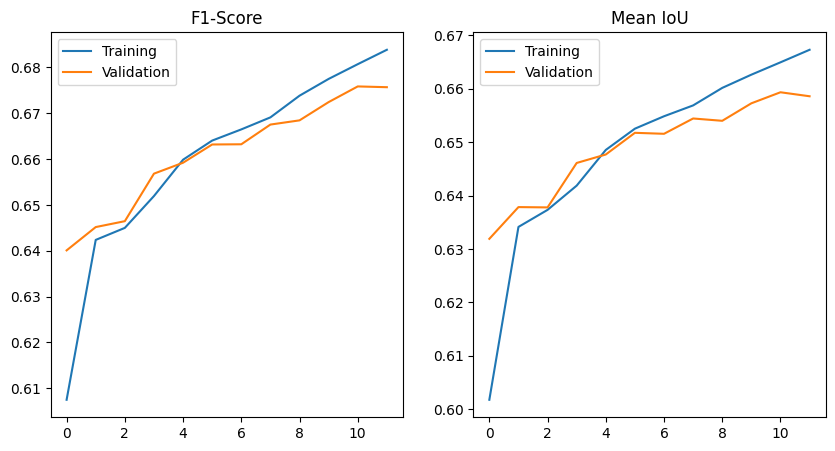

In [23]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(history.history['f1-score'], label='Training')
ax[0].plot(history.history['val_f1-score'], label='Validation')
ax[0].legend()
ax[0].set_title('F1-Score')

ax[1].plot(history.history['iou_score'], label='Training')
ax[1].plot(history.history['val_iou_score'], label='Validation')
ax[1].legend()
ax[1].set_title('Mean IoU')

fig

In [26]:
loss_res, iou_res, f1_res = model.evaluate(testing)
print('Testing Set Loss:', loss_res)
print('Testing Set IoU:', iou_res)
print('Testing Set F1 Score:', f1_res)

500/500 [==============================] - 63s 126ms/step - loss: 0.9916 - iou_score: 0.6610 - f1-score: 0.6784
Testing Set Loss: 0.9915764927864075
Testing Set IoU: 0.6610053777694702
Testing Set F1 Score: 0.6783515810966492


<font size="4">Overall, the performance of the model is decent, but there is still a lot of room for improvement. Before getting to this point, the model was fitted using 10000 256x256 images and using similar hyperparameters. Those tests resulted in IoU and F1 scores of around 0.3. This would indicate that increasing the resolution to 1024x1024 would further improve the model, but without more memory in my machine, this isn't possible to achieve.
<br><br> In conclusion, the model produced is good enough for the current casual use case, but the loss indicated that there is a lot of room for improvement. On top of the need for more computational power, which was mentioned above, the loss function and its hyperparameters should be tuned to further improve the model. Even at its current state. Also, ensemble learning with a different backbone or neural network architecture, such FCN or Mask R-CNN, would also improve the model.
</font>

# Post Processing
<font size="4">To clean up the masks, I used DenseCRF, which attempts to make the mask more coherent while keeping detail. This is why I chose DenseCRF over some other morphology techniques.</font>

``` python
# convert softmax output/model output to unary
# unary: possibility that a pixel belongs to a class
mod_m = np.transpose(sm_mask_img, (2, 0, 1))
unary = unary_from_softmax(mod_m)
unary = np.ascontiguousarray(unary)

d = dcrf.DenseCRF2D(512, 512, 66)
d.setUnaryEnergy(unary)
d.addPairwiseGaussian(sxy=3, compat=3)
d.addPairwiseBilateral(sxy=80, srgb=13, rgbim=base_img.copy(), compat=10)

# set the number of iterations
Q = d.inference(40)
progress_bar.progress(90, text='Processing Mask')

# Get the refined segmentation mask
refined_mask = np.argmax(Q, axis=0).reshape((512, 512))
```